In [ ]:
!pip install torcheval
!pip install yadisk
!rm -rf sample_data

In [ ]:
import yadisk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from collections import defaultdict

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torcheval.metrics.functional import multiclass_f1_score

import tensorflow as tf
from tensorflow import summary

import datetime

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [ ]:
%%time

token_key = "<PRIVATE_YANDEX_TOKEN_HERE>"
dataset_ya_path = "cv_kaggle/vk-made-sports-image-classification.zip"
dataset_local_path = "data.zip"

y = yadisk.YaDisk(token=token_key)
y.download(dataset_ya_path, dataset_local_path)

In [ ]:
!unzip data.zip
!rm data.zip

In [ ]:
train_csv_path = 'train.csv'
test_csv_path = 'test.csv'
train_img_dir = 'train/'
test_img_dir = 'test/'

In [ ]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [ ]:
name_to_label = dict(zip(train_df.label.unique(), np.arange(train_df.label.nunique())))

In [ ]:
label_to_name = {v: k for k, v in name_to_label.items()}

### EDA

In [ ]:
num_classes = train_df.label.nunique()

In [ ]:
print(f"Train image dataset size: {train_df.shape[0]}")
print(f"Test image dataset size: {test_df.shape[0]}")
print(f"Number of target classes: {num_classes}")

Train image dataset size: 45373
Test image dataset size: 19446
Number of target classes: 30


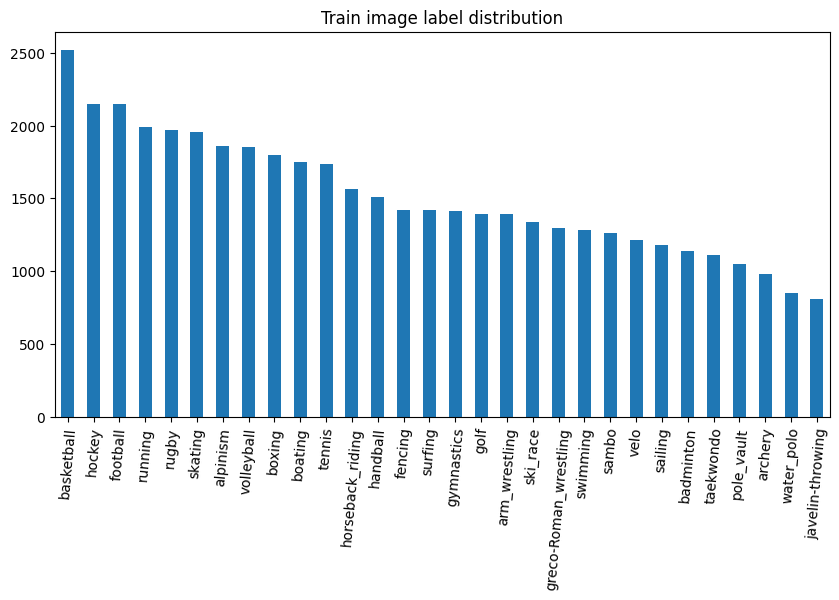

In [ ]:
# train label distribution
ax = train_df.label.value_counts().plot.bar(rot=85, figsize=(10, 5))
ax.set_title('Train image label distribution')
plt.show()

In [ ]:
# get unique sizes of images:
train_img_sizes = defaultdict(int)
test_img_sizes = defaultdict(int)

for img_name in tqdm(os.listdir(train_img_dir)):
    img_path = os.path.join(train_img_dir, img_name)
    img = Image.open(img_path)
    img_size = np.array(img).shape
    train_img_sizes[img_size] += 1

for img_name in tqdm(os.listdir(test_img_dir)):
    img_path = os.path.join(test_img_dir, img_name)
    img = Image.open(img_path)
    img_size = np.array(img).shape
    test_img_sizes[img_size] += 1

100%|██████████| 19446/19446 [01:46<00:00, 181.78it/s]


In [ ]:
sorted(list(zip(img_sizes.values(), img_sizes.keys())), reverse=True)

__Note:__ В датасете имеются изображения и портретной и альбомной ориентации. Мне кажется для первоначального приближения их можно скастить к виду 450 x 300

In [ ]:
def plot_samples(dataset_path: str,
                 df_csv: pd.DataFrame,
                 label: str = 'all',
                 n_rows: int = 2,
                 n_cols: int = 2,
                 figure_size: tuple = (10, 10)):
  
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figure_size)
    n_imgs = n_rows * n_cols

    has_labels = 'label' in df_csv.columns

    if label != 'all':
        if has_labels: 
            df_csv = df_csv[df_csv.label == label]
        else:
            raise RuntimeError("Test dataset does not have labels! Do not use 'label' argument")

    sample_names = df_csv.sample(n_imgs)

    img_names = sample_names.image_id
    img_labels = sample_names.label if has_labels else None
    

    for i in range(n_rows):
        for j in range(n_cols):
            img_index = i * n_cols + j
            img_path = os.path.join(dataset_path, img_names.iloc[img_index])
            
            img = Image.open(img_path)
            img_label = img_labels.iloc[img_index] if (img_labels is not None) else ''

            axes = ax[i][j] if n_rows > 1 else ax[j]
            axes.imshow(img)
            axes.set_title(img_label)
            axes.axis("off")

In [ ]:
plot_samples(train_img_dir, train_df, 'all', 2, 5, figure_size=(10, 5))

In [ ]:
plot_samples(test_img_dir, test_df, 'all', 2, 5, figure_size=(10, 5))

<ipython-input-104-00e9026e6761>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(n_rows, n_cols, figsize=figure_size)


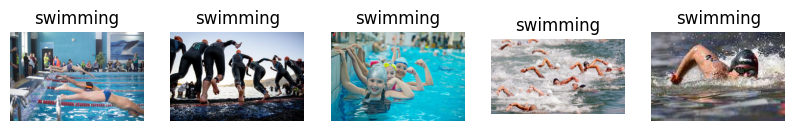

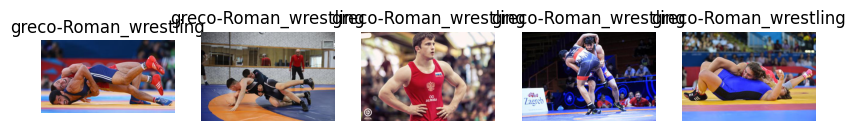

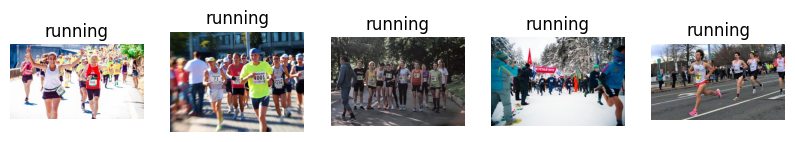

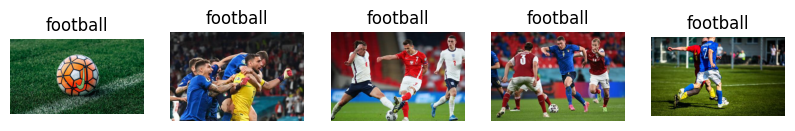

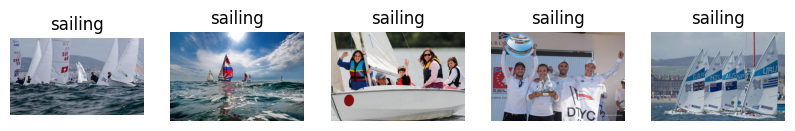

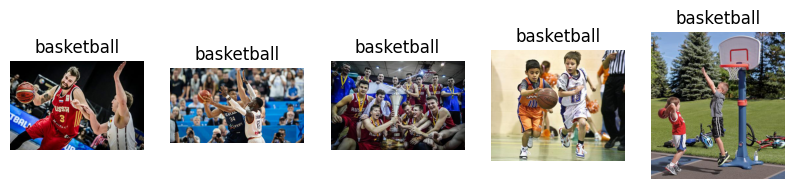

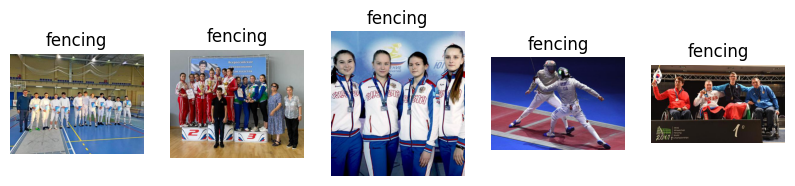

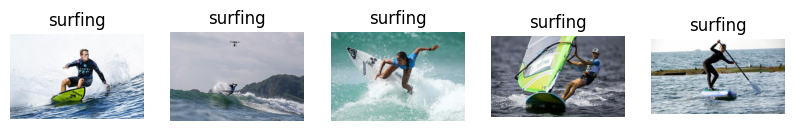

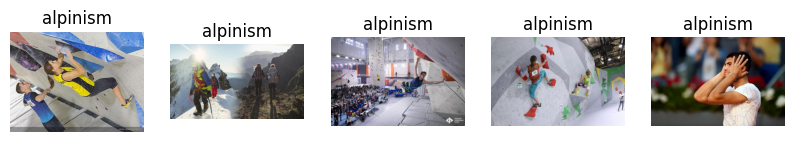

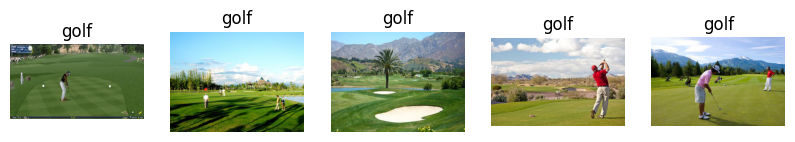

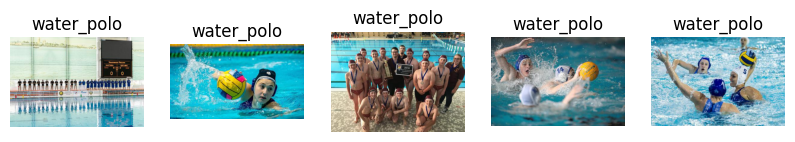

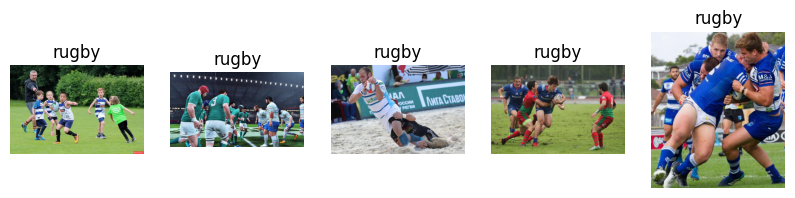

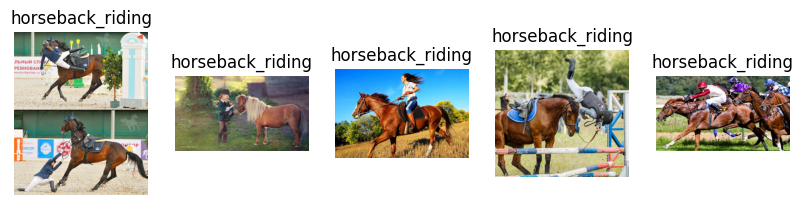

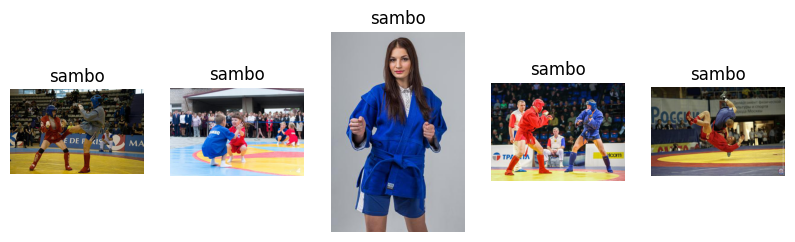

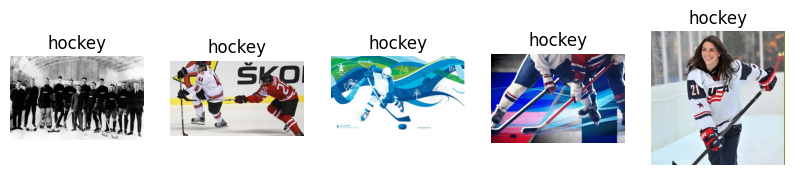

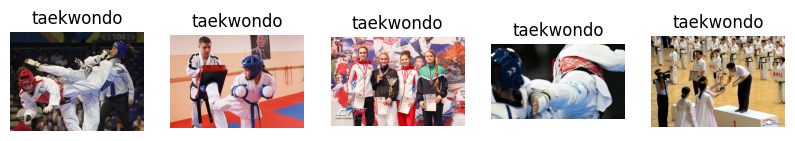

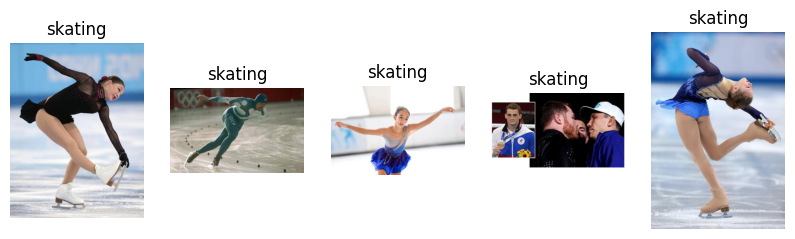

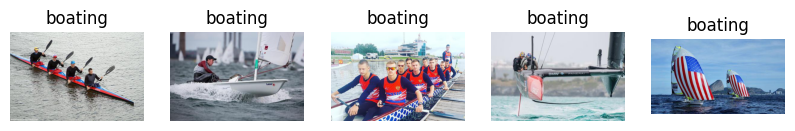

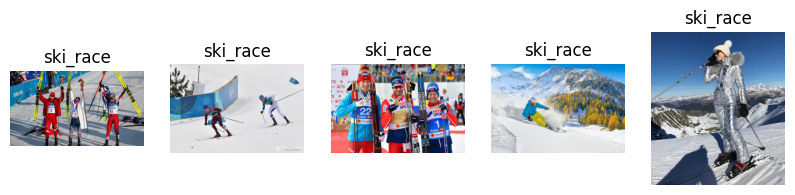

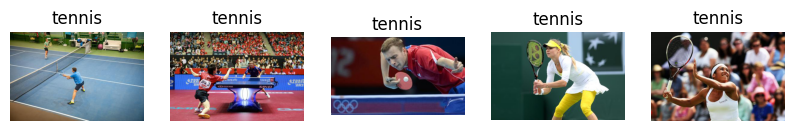

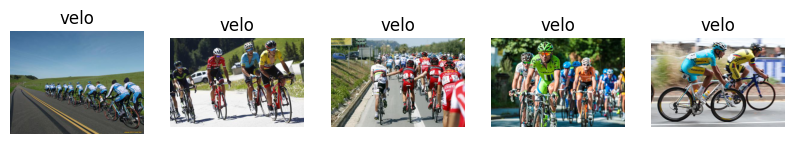

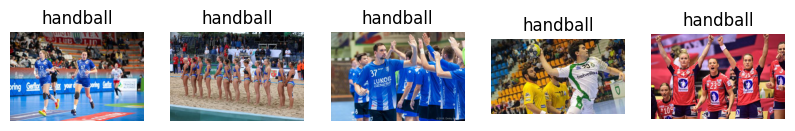

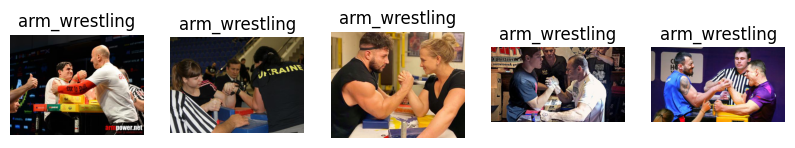

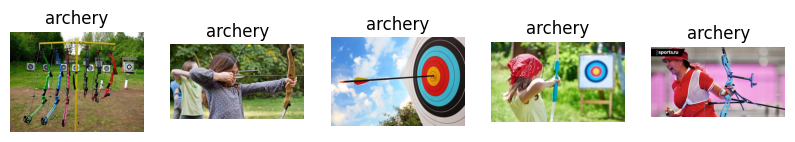

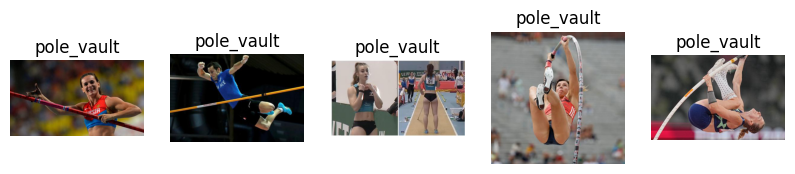

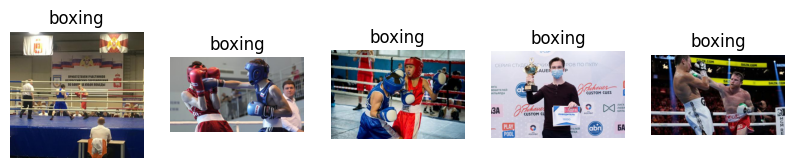

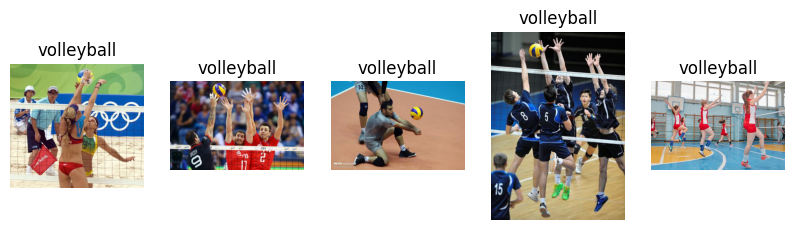

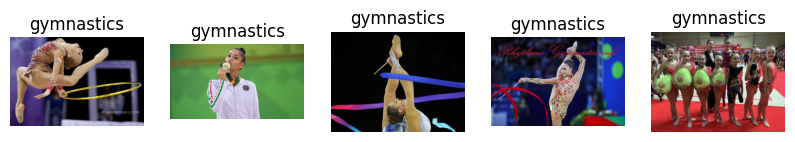

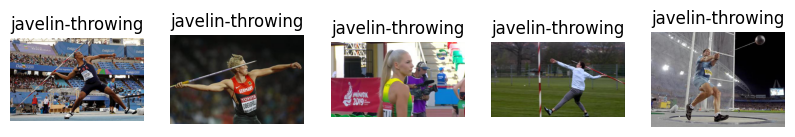

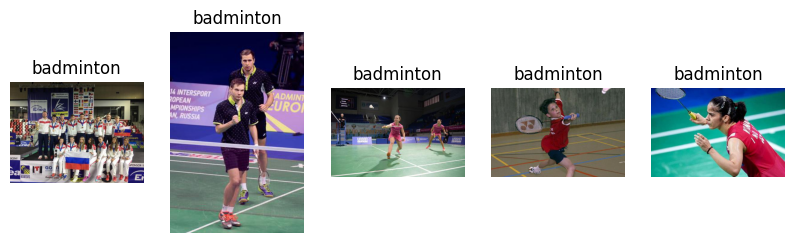

In [ ]:
for label in name_to_label.keys():
    plot_samples(train_img_dir, train_df, label, 1, 5, figure_size=(10, 5))

__Note:__ Можно заметить, что в датасете присутсвуют картинки, которые нек содержат специфичных особеностей. То есть если мы не знаем контекста, то человеку будет непонятно в какую категорию отнести объект. Например: фото спортсмена без атрибутики или спорстмена с медалью. Кажется, что такие объекты могут вредить обучению и хорошо бы их удалить из корпуса (вручную)

### Split data into train/val/test

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df,
                                    random_state=153,
                                    test_size=0.05,
                                    stratify=train_df.label)

In [ ]:
print(f"Train image dataset size: {train_df.shape[0]}")
print(f"Validation image dataset size: {val_df.shape[0]}")
print(f"Test image dataset size: {test_df.shape[0]}")

Train image dataset size: 43104
Validation image dataset size: 2269
Test image dataset size: 19446


In [ ]:
csv_path = 'csv/'
os.makedirs(csv_path, exist_ok=True)
train_df.to_csv(os.path.join(csv_path, 'train.csv'), header=True, index=False)
val_df.to_csv(os.path.join(csv_path, 'val.csv'), header=True, index=False)
test_df.to_csv(os.path.join(csv_path, 'test.csv'), header=True, index=False)

### Dataset & Dataloaders

In [ ]:
transforms_storage = dict()

transforms_storage['default'] = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((300, 450), antialias=True),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                    ])


transforms_storage['advanced_train'] = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomAffine(degrees=0, scale=(1, 1.2)),
                                        transforms.Resize((300, 450), antialias=True),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                    ])

transforms_storage['advanced_test'] = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((300, 450), antialias=True),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                    ])

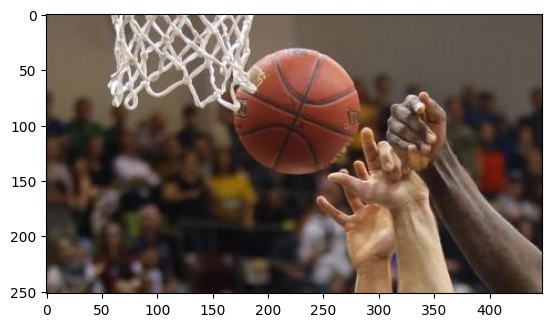

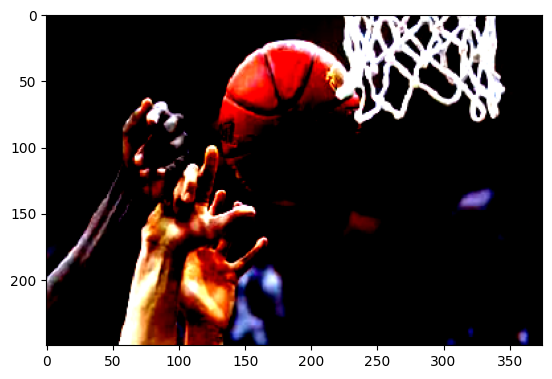

In [ ]:
img = Image.open(
    os.path.join(train_img_dir, np.random.choice(os.listdir(train_img_dir), 1)[0])
).convert('RGB')

plt.imshow(img)
plt.show()
plt.imshow(transforms_storage['advanced_train'](img).permute(1, 2, 0))

In [ ]:
def target_transform(label_str):
    return name_to_label[label_str]

In [ ]:
class SportDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_info = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        self.has_labels = 'label' in self.img_info.columns

    def __len__(self):
        return len(self.img_info)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_info.image_id.iloc[idx])
        image = Image.open(img_path).convert('RGB')
        
        label = self.img_info.label.iloc[idx] if self.has_labels else None
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform and (label is not None):
            label = self.target_transform(label)

        if label is not None:
            return image, label
        else:
            return image

In [ ]:
transformer_train = transforms_storage['advanced_train']
transformer_test = transforms_storage['advanced_test']
transformer_target_main = target_transform

train_dataset = SportDataset(os.path.join('csv', 'train.csv'),
                             train_img_dir,
                             transform=transformer_train,
                             target_transform=transformer_target_main)

val_dataset = SportDataset(os.path.join('csv', 'val.csv'),
                           train_img_dir,
                           transform=transformer_test,
                           target_transform=transformer_target_main)

test_dataset = SportDataset(os.path.join('csv', 'test.csv'),
                            test_img_dir,
                            transform=transformer_test,
                            target_transform=None)

In [ ]:
batch_size = 16
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Model preparing

In [ ]:
model_ydisk_path = 'cv_kaggle/models_eff/effnet_b4_7_0_8840.pth'
scheduler_ydisk_path = 'cv_kaggle/models_eff/steplr_7.pth'
logs_ydisk_path = 'cv_kaggle/models_eff/logs_epoch_7.zip'

model_local_path = model_ydisk_path.split('/')[-1]
scheduler_local_path = scheduler_ydisk_path.split('/')[-1]
logs_local_path = logs_ydisk_path.split('/')[-1]

y.download(model_ydisk_path, model_local_path)
y.download(scheduler_ydisk_path, scheduler_local_path)
y.download(logs_ydisk_path, logs_local_path)

In [ ]:
import shutil
shutil.unpack_archive(logs_local_path, '.')

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
# model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)
model.classifier.fc = torch.nn.Linear(in_features=model.classifier.fc.in_features, out_features=num_classes, bias=True)

model.load_state_dict(torch.load(model_local_path))
model.to(device)
model.train()


In [ ]:
optimizer_params = {
    'params' : model.parameters(),
    'lr' : 0.0001,
}

optimizer = torch.optim.Adam(**optimizer_params)

lr_scheduler_params = {
    'optimizer' : optimizer,
    'step_size' : 10,
    'gamma' : 0.1,
}

scheduler = torch.optim.lr_scheduler.StepLR(**lr_scheduler_params)
# scheduler.load_state_dict(torch.load(scheduler_local_path))

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
import shutil

def copy_file_to_ydisk(source_path, destination_path):
    y.upload(source_path, destination_path)

def save_model(model,
               scheduler=None,
               epoch_number=0,
               val_score=0,
               model_prefix='model',
               scheduler_prefix='scheduler',
               tmp_save_dir='.'):
  
    model_save_path = os.path.join(tmp_save_dir, f'{model_prefix}_{epoch_number}_0_{int(val_score * 10**4)}.pth')
    torch.save(model.state_dict(), model_save_path)
    
    scheduler_save_path = None
    if scheduler is not None:
        scheduler_save_path = os.path.join(tmp_save_dir, f'{scheduler_prefix}_{epoch_number}.pth')
        torch.save(model.state_dict(), scheduler_save_path)

    return model_save_path, scheduler_save_path

def save_logs(logs_dir, output_filename='logs', archive_type='zip', epoch=0):
    return shutil.make_archive(output_filename + f'_epoch_{epoch}', archive_type, logs_dir)

In [ ]:
# !rm -rf *.zip
# !rm -rf *.pth

In [ ]:
current_time = '1681081726.472913' # str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
val_log_dir = 'logs/tensorboard/val/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time

train_summary_writer = summary.create_file_writer(train_log_dir)
val_summary_writer = summary.create_file_writer(val_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)


In [ ]:
model_ydisk_save_dir = "cv_kaggle/models_eff/"
model_name = "effnet_b4"
scheduler_name = "steplr"
save_only_best = False

n_epochs = 30
n_epochs_trained = 7
best_f1_score = -1

for n_ep in range(n_epochs_trained, n_epochs):
    # training 
    model.train()
    train_loss = 0
    for (batch_images, batch_labels) in tqdm(train_dataloader):

        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        output = model(batch_images)
        loss = criterion(output, batch_labels)
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=n_ep)

    # validation  
    model.eval()
    with torch.no_grad():
        val_metrics = []
        val_loss = 0
        predicted_labels = None
        target_labels = None

        for (batch_images, batch_labels) in tqdm(val_dataloader):
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            output = model(batch_images)
            output_labels = output.argmax(dim=1)

            loss = criterion(output, batch_labels)
            val_loss += loss

            if predicted_labels is None:
                predicted_labels = output_labels
                target_labels = batch_labels
            else:
                predicted_labels = torch.cat((predicted_labels, output_labels), 0)
                target_labels = torch.cat((target_labels, batch_labels), 0)

        f1_micro_score = multiclass_f1_score(input=predicted_labels,
                                              target=target_labels,
                                              num_classes=num_classes,
                                              average='micro')
            
        # scheduler.step(val_loss)
        val_loss = val_loss.item()
        val_metric = f1_micro_score.item()

        with val_summary_writer.as_default():
            tf.summary.scalar('f1_micro', val_metric, step=n_ep)

        with val_summary_writer.as_default():
            tf.summary.scalar('loss', val_loss, step=n_ep)

        print(f"Epoch #{n_ep}: validation f1_micro = {val_metric}")
    
        scheduler.step()

        if (not save_only_best) or (val_metric > best_f1_score):
            best_f1_score = val_metric
            model_path, scheduler_path = save_model(model,
                                                    scheduler=scheduler,
                                                    epoch_number=n_ep+1,
                                                    val_score=val_metric,
                                                    model_prefix=model_name,
                                                    scheduler_prefix=scheduler_name,
                                                    tmp_save_dir='.')
            

            copy_file_to_ydisk(model_path,
                               os.path.join(model_ydisk_save_dir, model_path.split('/')[-1]))
            
            copy_file_to_ydisk(scheduler_path,
                               os.path.join(model_ydisk_save_dir, scheduler_path.split('/')[-1]))                    

    logs_archive_path = save_logs('logs', 'logs', 'zip', n_ep+1)
    copy_file_to_ydisk(logs_archive_path, os.path.join(model_ydisk_save_dir, logs_archive_path.split('/')[-1]))

100%|██████████| 142/142 [00:24<00:00,  5.90it/s]


Epoch #7: validation f1_micro = 0.9250771403312683


100%|██████████| 142/142 [00:23<00:00,  5.97it/s]


Epoch #8: validation f1_micro = 0.9268400073051453


100%|██████████| 142/142 [00:23<00:00,  5.96it/s]


Epoch #9: validation f1_micro = 0.9272806644439697


100%|██████████| 142/142 [00:23<00:00,  5.99it/s]


Epoch #10: validation f1_micro = 0.930365800857544


100%|██████████| 142/142 [00:24<00:00,  5.89it/s]


Epoch #11: validation f1_micro = 0.9299250841140747


100%|██████████| 142/142 [00:23<00:00,  5.97it/s]


Epoch #12: validation f1_micro = 0.9356545209884644


100%|██████████| 142/142 [00:23<00:00,  5.94it/s]


Epoch #13: validation f1_micro = 0.9338915944099426


100%|██████████| 142/142 [00:23<00:00,  5.99it/s]


Epoch #14: validation f1_micro = 0.9347730278968811


100%|██████████| 142/142 [00:24<00:00,  5.90it/s]


Epoch #15: validation f1_micro = 0.9312472343444824


100%|██████████| 142/142 [00:24<00:00,  5.87it/s]


Epoch #16: validation f1_micro = 0.9272806644439697


100%|██████████| 142/142 [00:23<00:00,  5.92it/s]


Epoch #17: validation f1_micro = 0.9325693845748901


100%|██████████| 142/142 [00:24<00:00,  5.85it/s]


Epoch #18: validation f1_micro = 0.9312472343444824


 83%|████████▎ | 2225/2694 [22:30<04:47,  1.63it/s]

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/tensorboard

### Make prediction


In [ ]:
model_ydisk_path = 'cv_kaggle/models/resnext50_13_0_9109.pth'
model_local_path = model_ydisk_path.split('/')[-1]
y.download(model_ydisk_path, model_local_path)

<ResourceLinkObject{'href': 'https://cloud-api.yandex.net/v1/disk/resources?path=disk%3A%2Fcv_kaggle%2Fmodels%2Fresnext50_13_0_9109.pth', 'method': 'GET', 'templated': False, 'path': 'disk:/cv_kaggle/models/resnext50_13_0_9109.pth', 'public_key': None, 'public_url': None}>

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)
model.load_state_dict(torch.load(model_local_path))
model.to(device)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
predicted_labels = None
with torch.no_grad():
    for batch_images in tqdm(test_dataloader):
        batch_images = batch_images.to(device)

        output = model(batch_images)
        output_labels = output.argmax(dim=1)

        if predicted_labels is None:
            predicted_labels = output_labels
        else:
            predicted_labels = torch.cat((predicted_labels, output_labels), 0)

100%|██████████| 608/608 [03:36<00:00,  2.80it/s]


In [ ]:
predicted_labels.size()

torch.Size([19446])

In [ ]:
preds = predicted_labels.cpu().detach().numpy()

In [ ]:
preds.shape

(19446,)

In [ ]:
images_ids = test_dataset.img_info.image_id.values

In [ ]:
submit_df = pd.DataFrame(zip(images_ids, preds), columns=['image_id', 'label'])

In [ ]:
submit_df['label'] = submit_df.label.map(label_to_name)

In [ ]:
submit_df.to_csv('submit.csv', header=True, index=False)

In [ ]:
pd.read_csv('submit.csv').sample(5)

image_id       label
18375  d56b7f8b-d80f-4287-b823-937534ea75fb.jpeg  basketball
455    f4560b8d-ef64-4e1b-a451-23c6b5306953.jpeg     boating
15214  4b132b6d-d73e-435d-9c18-200e34485cb0.jpeg  pole_vault
9447   b16e9285-5638-434a-998f-82b5188e37be.jpeg    football
1116   ad469150-4809-4b0b-8a92-0c10717b9914.jpeg      tennis

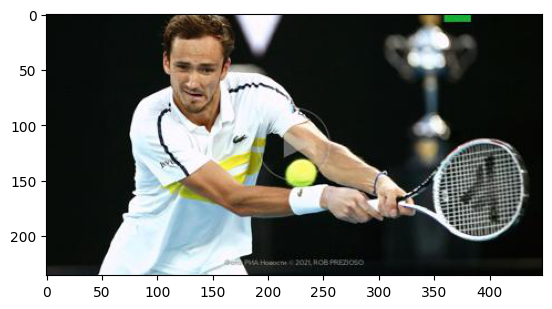

In [ ]:
id = 'ad469150-4809-4b0b-8a92-0c10717b9914.jpeg'
img = Image.open(f'test/{id}')

plt.imshow(img)

### Анализ ошибок

In [ ]:
predicted_labels = None
target_labels = None

with torch.no_grad():
    for (batch_images, batch_labels) in tqdm(val_dataloader):
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        output = model(batch_images)
        output_labels = output.argmax(dim=1)

        if predicted_labels is None:
            predicted_labels = output_labels
            target_labels = batch_labels
        else:
            predicted_labels = torch.cat((predicted_labels, output_labels), 0)
            target_labels = torch.cat((target_labels, batch_labels), 0)

100%|██████████| 142/142 [00:52<00:00,  2.72it/s]


In [ ]:
images_ids = val_dataset.img_info.image_id.values

In [ ]:
predicted_labels = predicted_labels.cpu().detach().numpy()
target_labels = target_labels.cpu().detach().numpy()

In [ ]:
target_labels.shape, predicted_labels.shape, images_ids.shape

((4538,), (4538,), (4538,))

In [ ]:
val_preds = pd.DataFrame(zip(images_ids, target_labels, predicted_labels), columns=['image_id', 'target', 'prediction'])

In [ ]:
val_preds.head()

image_id  target  prediction
0  36870861-f2c9-45af-bb8e-0d046d0a27e3.jpeg       7          17
1  c080349f-23f3-470c-84fc-c9cae42a1efd.jpeg      10          10
2  fd4472dd-152c-49a8-99f4-75d56ca04695.jpeg      29          29
3  1487e66d-8805-4c2c-a71f-5a5f8e19bac4.jpeg      24          24
4  dcc52e5d-c1f6-4572-8915-fb3d603afb2f.jpeg      27          27

In [ ]:
val_preds['target'] = val_preds.target.map(label_to_name)
val_preds['prediction'] = val_preds.prediction.map(label_to_name)

In [ ]:
val_preds.shape[0]

4538

In [ ]:
val_preds_err = val_preds[val_preds.target != val_preds.prediction]

In [ ]:
val_preds_err.head(10)

image_id         target  \
0    36870861-f2c9-45af-bb8e-0d046d0a27e3.jpeg        surfing   
9    7220cdb4-bd63-4331-83f8-a071ee8fa2ce.jpeg         tennis   
18   52480013-fc06-44a4-a55b-14035d747668.jpeg  arm_wrestling   
30   8d8c391e-6abc-493c-95e9-d6fab0f53cea.jpeg        surfing   
36   62b52c23-4c11-45dd-ad1a-70b9c606842f.jpeg     basketball   
43   213c3764-5423-431d-81b0-0e53ffd33e3d.jpeg         boxing   
50   d5c253cc-a33d-4e64-acc8-08f96a5c9ed6.jpeg          sambo   
85   419850a2-0216-49c1-b68e-e818c718209f.jpeg        fencing   
94   175ed0f8-9d4b-4478-84a9-73bf87746ea2.jpeg         boxing   
102  489b5050-050b-493a-8d7c-b4fdd5680630.jpeg        fencing   

                prediction  
0                  boating  
9               volleyball  
18                  boxing  
30                  tennis  
36                   rugby  
43              volleyball  
50   greco-Roman_wrestling  
85        horseback_riding  
94   greco-Roman_wrestling  
102                surfing

In [ ]:
val_preds_err.target.value_counts()

basketball               33
running                  28
handball                 27
alpinism                 25
boxing                   21
boating                  19
arm_wrestling            18
football                 17
swimming                 15
badminton                15
surfing                  14
greco-Roman_wrestling    14
sambo                    13
hockey                   13
sailing                  13
archery                  12
rugby                    12
volleyball               11
skating                  11
golf                     10
tennis                   10
gymnastics                9
fencing                   9
pole_vault                7
water_polo                6
taekwondo                 6
javelin-throwing          5
horseback_riding          4
ski_race                  4
velo                      3
Name: target, dtype: int64

In [ ]:
val_preds_err.prediction.value_counts()

boating                  29
basketball               27
volleyball               25
running                  24
boxing                   23
greco-Roman_wrestling    23
football                 20
skating                  19
swimming                 18
gymnastics               17
tennis                   17
ski_race                 15
surfing                  14
golf                     14
sailing                  12
rugby                    11
alpinism                 10
sambo                    10
fencing                   9
hockey                    9
javelin-throwing          9
badminton                 9
arm_wrestling             8
pole_vault                8
handball                  7
taekwondo                 5
horseback_riding          5
archery                   3
water_polo                2
velo                      2
Name: prediction, dtype: int64

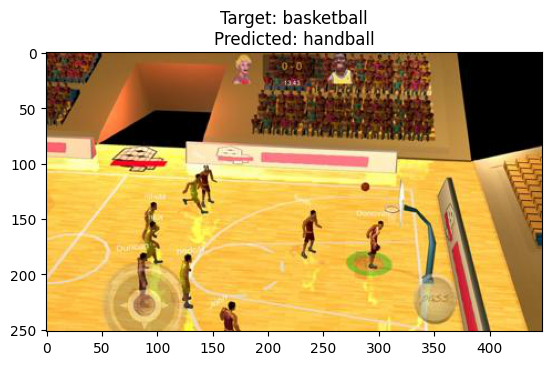

In [ ]:
sample = val_preds_err[val_preds_err.target == 'basketball'].sample(1)
id = sample.image_id.item()
target_name = sample.target.item()
pred_name = sample.prediction.item()

img = Image.open(f'train/{id}')

plt.title(f"Target: {target_name}\nPredicted: {pred_name}")
plt.imshow(img)
plt.show()